In [15]:
# from trainers.grpo_trainer import GRPOTrainer
from instruction_adapter import InstructionPlanDataset, PROMPT_WITH_FUCNTIONS_HINTS

In [ ]:
dataset_path = "dataset/optim_super_dataset_EASY_atomic.json"
model_name = "Qwen/Qwen2-0.5B-Instruct"


In [7]:
dataset = InstructionPlanDataset(dataset_path)

dataset[0]

{'promnt': '\n        You control an agent in a 2D game with siplified Minecraft environment. You will need to provide a detailed step-by-step plan for following the user\'s instructions. \n        You must include all the preliminary steps that it needs to complete.\n        \n        You are controlling an agent in a 2D game set within a simplified Minecraft-like environment. \n        The agent starts from scratch with an empty inventory and no gathered resources. \n        Your task is to generate a step-by-step plan that enables the agent to follow a given user instruction.\n\n        What you must do:\n        - Break down the instruction into atomic actions the agent needs to perform.\n        - Include all necessary preliminary steps, such as gathering or crafting resources.\n        - Assume the agent has nothing at the beginning — you must plan from the ground up.\n        - Output your answer as a Python list of strings.\n        - Each string must represent one atomic skill

In [ ]:
from trl.trainer import GRPOConfig
training_args = GRPOConfig(
    output_dir=f"{model_name}-GRPO",
    
    bf16=True,
    
    logging_steps=10,
    num_iterations=2,
    
    gradient_checkpointing=True,
    use_vllm=False,
)

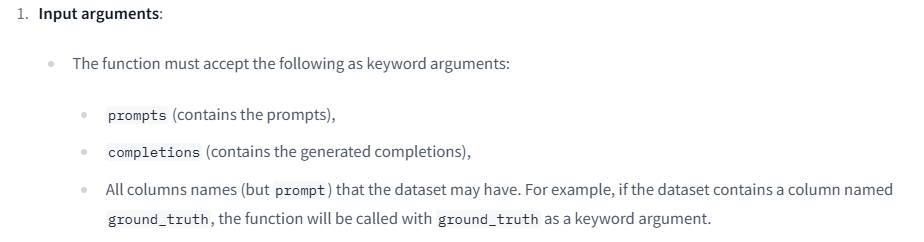

In [4]:
from transformers import AutoModelForCausalLM, AutoTokenizer

model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto", torch_dtype="auto")
tokenizer = AutoTokenizer.from_pretrained(model_name, device_map="auto", torch_dtype="auto")


[2025-05-14 21:50:51,704] [INFO] [real_accelerator.py:239:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/usr/bin/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status
/usr/bin/ld: cannot find -lcufile: No such file or directory
collect2: error: ld returned 1 exit status
Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


In [20]:

request = dataset[1]['promnt']

inputs = tokenizer(request, return_tensors="pt").to(model.device)
print(f'inputs: {len(inputs.tokens())}')
response = model.generate(**inputs, max_new_tokens=256)
print(tokenizer.decode(response[0], skip_special_tokens=True))

inputs: 648

        You control an agent in a 2D game with siplified Minecraft environment. You will need to provide a detailed step-by-step plan for following the user's instructions. 
        You must include all the preliminary steps that it needs to complete.
        
        You are controlling an agent in a 2D game set within a simplified Minecraft-like environment. 
        The agent starts from scratch with an empty inventory and no gathered resources. 
        Your task is to generate a step-by-step plan that enables the agent to follow a given user instruction.

        What you must do:
        - Break down the instruction into atomic actions the agent needs to perform.
        - Include all necessary preliminary steps, such as gathering or crafting resources.
        - Assume the agent has nothing at the beginning — you must plan from the ground up.
        - Output your answer as a Python list of strings.
        - Each string must represent one atomic skill invocation, w

In [14]:
print(response.shape)

torch.Size([1, 770])


In [1]:
import json
import pickle
import math
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForCausalLM
from trainers.grpo_trainer import GRPOTrainer, GRPOConfig, RewardFunc
from tqdm import tqdm
from transformers import Trainer



PROMPT_WITH_FUCNTIONS_HINTS = f"""
    You control an agent in a 2D game with siplified Minecraft environment. You will need to provide a detailed step-by-step plan for following the user's instructions. 
    You must include all the preliminary steps that it needs to complete.
    
    You are controlling an agent in a 2D game set within a simplified Minecraft-like environment. 
    The agent starts from scratch with an empty inventory and no gathered resources. 
    Your task is to generate a step-by-step plan that enables the agent to follow a given user instruction.

    What you must do:
    - Break down the instruction into atomic actions the agent needs to perform.
    - Include all necessary preliminary steps, such as gathering or crafting resources.
    - Assume the agent has nothing at the beginning — you must plan from the ground up.
    - Output your answer as a Python list of strings.
    - Each string must represent one atomic skill invocation, written on a separate line.

    Format for each step:
    "skill_name(arg1 = value1, arg2 = value2, ...)"
    - skill_name: the name of the primitive skill or action the agent will execute.
    - Inside the parentheses, list all required arguments with their names and corresponding values.

    Example:
    gather_resource(resource_type = wood)
    
    Each of the step agents will be implemented without knowledge of what it did before, so it can only rely on observation and the current step. Therefore, each step must be self-sufficient and not require knowledge of past steps.

    Existed skills:
    {{'explore': "'object'"}}
    {{'gather_resource': "'resource_type'"}}, 
    {{'place_item': "'item_type'}},
    {{'create_item': "'item_type_to_craft'"}},
    {{'defeat_enemy': "'enemy_type'"}},
    {{'eat': "'food_type'"}},


    Existed arguments:
    object: world
    resource_type: wood, stone, coal, diamond, iron, plant, water
    item_type: stone, table, plant, furnace
    item_type_to_craft: table, wooden sword, wooden_pickaxe, stone_sword, stone_pickaxe, iron_sword, iron_pickaxe
    enemy_type: zombie, skeleton, cow
    food_type: cow, plant, water
    
    "If the instruction doesn't specify what the agent needs to do and is more general—like 'Explore the world' or 'Go out and examine the world around you'—send explore(object=world). In this case, the plan should consist of only one step: "explore(object=world)"."

    Send your answer as a python list.
    Instruction: Make a pickaxe from wood
    Answer: 
    ["gather_resource(resource_type = wood)",
    "gather_resource(resource_type = wood)",
    "create_item(item_type = table)", 
    "gather_resource(resource_type = wood", 
    "gather_resource(resource_type = wood", 
    "create_item(item_type = wooden_pickaxe)"]

    Send your answer as a python list.
    Instruction: $INSTRUCTION$  
    Answer: 
    """



# 1. Оригинальный Dataset для инструкций и планов
class InstructionPlanDataset(Dataset):
    def __init__(self, path, tokenizer, max_length=512, use_mapping=False, min_reward=0.0):
        with open(path, 'r', encoding='utf-8') as f:
            raw = json.load(f)
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.examples = []
        instr_data = raw.get('instructions', {})
        # mapping   = raw.get('mapping_plan_to_instruction', {})
        for entry in instr_data.values():
            instr = entry.get('instruction')
            plans = entry.get('plan_options', [])
            rewards = entry.get('rewards', [])
            for plan, r in zip(plans, rewards):
                if r is None or math.isnan(r) or r<min_reward: continue
                self.examples.append({'instruction': instr, 'complections': plan, 'reward': float(r)})
        self.examples = [ex for ex in self.examples if ex['instruction'] and ex['complections']]
        
        promnts = [PROMPT_WITH_FUCNTIONS_HINTS.replace("$INSTRUCTION$", ex['instruction'].strip()) for ex in self.examples]
        
        tokenized = self.tokenizer(
            text=promnts, return_tensors="pt", padding=True, padding_side="left", add_special_tokens=False
        )
        promnt_ids = tokenized['input_ids'].squeeze(0)
        promnt_mask = tokenized['attention_mask'].squeeze(0)
        
        complections_text = [ex['complections'].strip() for ex in self.examples]
        
        tokenized = self.tokenizer(
            text=complections_text, return_tensors="pt", padding=True, padding_side="left", add_special_tokens=False
        )
        complections_ids = tokenized['input_ids'].squeeze(0)
        complections_mask = tokenized['attention_mask'].squeeze(0)

        for i in range(len(self.examples)):
            ex = self.examples[i]
            ex['promt_instr'] = promnts[i]
            ex['prompt_length'] = promnt_ids.size(1)
            ex['prompt_ids'] = promnt_ids[i]
            ex['prompt_mask'] = promnt_mask[i]
            ex['complections_ids'] = complections_ids[i]
            ex['complections_mask'] = complections_mask[i]
            ex['complections'] = complections_text[i]

        
    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        ex = self.examples[idx]
        return {
            'prompt_length': ex['prompt_length'],
            'instruction': ex['instruction'],
            'complection': ex['complections'],
            'prompt': ex['instruction'],
            'prompt_ids': ex['prompt_ids'],
            'prompt_mask': ex['prompt_mask'],
            'completion_ids': ex['complections_ids'],
            'completion_mask': ex['complections_mask'],
            'rewards': torch.tensor(ex['reward'], dtype=torch.float)
        }

# # 2. Предпроцессинг: кеширование logits
# def cache_logits(json_path, cache_path, model_name, batch_size=6, max_length=512):
#     tokenizer = AutoTokenizer.from_pretrained(model_name)
#     model     = AutoModelForCausalLM.from_pretrained(model_name).eval()
#     dataset   = InstructionPlanDataset(json_path, tokenizer, max_length=max_length)
#     loader    = DataLoader(dataset, batch_size=batch_size)
#     cache = []
#     with torch.no_grad():
#         for batch in tqdm(loader):
            
#             for i in range(in_ids.size(0)):
#                 cache.append({
#                     'input_ids': in_ids[i].tolist(),
#                     'attention_mask': attn[i].tolist(),
#                     'labels': labels[i].tolist(),
#                     'old_per_token_logps': per_tok[i].tolist(),
#                     'ref_per_token_logps': ref_tok[i].tolist(),
#                     'reward': rewards[i].item()
#                 })
#     with open(cache_path, 'wb') as f:
#         pickle.dump(cache, f)
#     print(f"Cached {len(cache)} examples to {cache_path}")

# 3. Dataset для закешированных logits
class CachedLogitsDataset(Dataset):
    def __init__(self, cache_path, pad_token_id):
        with open(cache_path, 'rb') as f:
            self.cache = pickle.load(f)
        self.pad = pad_token_id
    def __len__(self):
        return len(self.cache)
    def __getitem__(self, idx):
        ex = self.cache[idx]
        return {
            'prompt_text'
            'input_ids': torch.tensor(ex['input_ids'], dtype=torch.long),
            'attention_mask': torch.tensor(ex['attention_mask'], dtype=torch.long),
            'labels': torch.tensor(ex['labels'], dtype=torch.long),
            'old_per_token_logps': torch.tensor(ex['old_per_token_logps'], dtype=torch.float),
            'ref_per_token_logps': torch.tensor(ex['ref_per_token_logps'], dtype=torch.float),
            'reward': torch.tensor(ex['reward'], dtype=torch.float)
        }

[2025-05-15 17:58:31,046] [INFO] [real_accelerator.py:239:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/usr/bin/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status
/usr/bin/ld: cannot find -lcufile: No such file or directory
collect2: error: ld returned 1 exit status


In [2]:
# Copyright 2025 The HuggingFace Team. All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import os
import textwrap
import warnings
from collections import defaultdict
from contextlib import nullcontext
from typing import Any, Callable, Optional, Sized, Union

import torch
import torch.utils.data
import transformers
from accelerate.utils import broadcast_object_list, gather, gather_object, is_peft_model, set_seed
from datasets import Dataset, IterableDataset
from packaging import version
from torch import nn
from torch.utils.data import Sampler
from transformers import (
    AutoModelForCausalLM,
    AutoModelForSequenceClassification,
    AutoTokenizer,
    GenerationConfig,
    PreTrainedModel,
    PreTrainedTokenizerBase,
    Trainer,
    TrainerCallback,
    is_wandb_available,
)
from transformers.integrations.deepspeed import is_deepspeed_zero3_enabled
from transformers.utils import is_peft_available

from trl.data_utils import apply_chat_template, is_conversational, maybe_apply_chat_template
from trl.extras.profiling import profiling_context, profiling_decorator
from trl.extras.vllm_client import VLLMClient
from trl.import_utils import is_deepspeed_available, is_rich_available, is_vllm_available
from trl.models import create_reference_model, prepare_deepspeed, unwrap_model_for_generation
from trl.trainer.callbacks import SyncRefModelCallback
from trl.trainer.grpo_config import GRPOConfig
from trl.trainer.utils import (
    generate_model_card,
    get_comet_experiment_url,
    pad,
    print_prompt_completions_sample,
    selective_log_softmax,
)


if is_deepspeed_available():
    import deepspeed

if is_peft_available():
    from peft import PeftConfig, get_peft_model


if is_wandb_available():
    import wandb

# What we call a reward function is a callable that takes a list of prompts and completions and returns a list of
# rewards. When it's a string, it's a model ID, so it's loaded as a pretrained model.
RewardFunc = Union[str, PreTrainedModel, Callable[[list, list], list[float]]]


class RepeatRandomSampler(Sampler):
    """
    Sampler that repeats the indices of a dataset in a structured manner.

    Args:
        data_source (`Sized`):
            Dataset to sample from.
        mini_repeat_count (`int`):
            Number of times to repeat each index per batch.
        batch_size (`int`, *optional*, defaults to `1`):
            Number of unique indices per batch.
        repeat_count (`int`, *optional*, defaults to `1`):
            Number of times to repeat the full sampling process.
        seed (`int` or `None`, *optional*, defaults to `None`):
            Random seed for reproducibility (only affects this sampler).

    Example:
    ```python
    >>> sampler = RepeatRandomSampler(["a", "b", "c", "d", "e", "f", "g"], mini_repeat_count=2, batch_size=3, repeat_count=4)
    >>> list(sampler)
    [4, 4, 3, 3, 0, 0,
     4, 4, 3, 3, 0, 0,
     4, 4, 3, 3, 0, 0,
     4, 4, 3, 3, 0, 0,

     1, 1, 2, 2, 6, 6,
     1, 1, 2, 2, 6, 6,
     1, 1, 2, 2, 6, 6,
     1, 1, 2, 2, 6, 6]
    ```

    ```txt
    mini_repeat_count = 3
          -   -   -
         [0,  0,  0,  1,  1,  1,  2,  2,  2,  3,  3,  3,      |
          4,  4,  4,  5,  5,  5,  6,  6,  6,  7,  7,  7,      |
          8,  8,  8,  9,  9,  9, 10, 10, 10, 11, 11, 11,      |
                                                                repeat_count = 2
          0,  0,  0,  1,  1,  1,  2,  2,  2,  3,  3,  3,      |
          4,  4,  4,  5,  5,  5,  6,  6,  6,  7,  7,  7,      |
          8,  8,  8,  9,  9,  9, 10, 10, 10, 11, 11, 11, ...] |
          ---------   ---------   ---------   ---------
           ---------   ---------   ---------   ---------
            ---------   ---------   ---------   ---------
                         batch_size = 12
    ```
    """

    def __init__(
        self,
        data_source: Sized,
        mini_repeat_count: int,
        batch_size: int = 1,
        repeat_count: int = 1,
        seed: Optional[int] = None,
    ):
        self.data_source = data_source
        self.mini_repeat_count = mini_repeat_count
        self.batch_size = batch_size
        self.repeat_count = repeat_count
        self.num_samples = len(data_source)
        self.seed = seed
        self.generator = torch.Generator()  # Create a local random generator
        if seed is not None:
            self.generator.manual_seed(seed)

    def __iter__(self):
        # E.g., [2, 4, 3, 1, 0, 6, 5] (num_samples = 7)
        indexes = torch.randperm(self.num_samples, generator=self.generator).tolist()

        #    [2, 4, 3, 1, 0, 6, 5]
        # -> [[2, 4, 3], [1, 0, 6], [5]]  (batch_size = 3)
        indexes = [indexes[i : i + self.batch_size] for i in range(0, len(indexes), self.batch_size)]

        #    [[2, 4, 3], [1, 0, 6], [5]]
        # -> [[2, 4, 3], [1, 0, 6]]
        indexes = [chunk for chunk in indexes if len(chunk) == self.batch_size]

        for chunk in indexes:
            for _ in range(self.repeat_count):
                for index in chunk:
                    for _ in range(self.mini_repeat_count):
                        yield index

    def __len__(self) -> int:
        return self.num_samples * self.mini_repeat_count * self.repeat_count


class GRPOTrainer(Trainer):
    """
    Trainer for the Group Relative Policy Optimization (GRPO) method. This algorithm was initially proposed in the
    paper [DeepSeekMath: Pushing the Limits of Mathematical Reasoning in Open Language Models](https://huggingface.co/papers/2402.03300).

    Example:

    ```python
    from datasets import load_dataset
    from trl import GRPOTrainer

    dataset = load_dataset("trl-lib/tldr", split="train")

    def reward_func(completions, **kwargs):
        # Dummy reward function that rewards completions with more unique letters.
        return [float(len(set(completion))) for completion in completions]

    trainer = GRPOTrainer(
        model="Qwen/Qwen2-0.5B-Instruct",
        reward_funcs=reward_func,
        train_dataset=dataset,
    )

    trainer.train()
    ```

    Args:
        model (`Union[str, PreTrainedModel]`):
            Model to be trained. Can be either:

            - A string, being the *model id* of a pretrained model hosted inside a model repo on huggingface.co, or
              a path to a *directory* containing model weights saved using
              [`~transformers.PreTrainedModel.save_pretrained`], e.g., `'./my_model_directory/'`. The model is
              loaded using [`~transformers.AutoModelForCausalLM.from_pretrained`] with the keywork arguments
              in `args.model_init_kwargs`.
            - A [`~transformers.PreTrainedModel`] object. Only causal language models are supported.
        reward_funcs (`Union[RewardFunc, list[RewardFunc]]`):
            Reward functions to be used for computing the rewards. To compute the rewards, we call all the reward
            functions with the prompts and completions and sum the rewards. Can be either:

            - A single reward function, such as:
                - A string: The *model ID* of a pretrained model hosted inside a model repo on huggingface.co, or a
                path to a *directory* containing model weights saved using
                [`~transformers.PreTrainedModel.save_pretrained`], e.g., `'./my_model_directory/'`. The model is loaded
                using [`~transformers.AutoModelForSequenceClassification.from_pretrained`] with `num_labels=1` and the
                keyword arguments in `args.model_init_kwargs`.
                - A [`~transformers.PreTrainedModel`] object: Only sequence classification models are supported.
                - A custom reward function: The function is provided with the prompts and the generated completions,
                  plus any additional columns in the dataset. It should return a list of rewards. Custom reward
                  functions can also return None when the reward is not applicable to those samples. This is useful for
                  multi-task training where different reward functions apply to different types of samples. When a
                  reward function returns None for a sample, that reward function is excluded from the reward
                  calculation for that sample. For more details, see
                  [Using a custom reward function](#using-a-custom-reward-function).
            - A list of reward functions, where each item can independently be any of the above types. Mixing different
            types within the list (e.g., a string model ID and a custom reward function) is allowed.
        args ([`GRPOConfig`], *optional*, defaults to `None`):
            Configuration for this trainer. If `None`, a default configuration is used.
        train_dataset ([`~datasets.Dataset`] or [`~datasets.IterableDataset`]):
            Dataset to use for training. It must include a column `"prompt"`. Any additional columns in the dataset is
            ignored. The format of the samples can be either:

            - [Standard](dataset_formats#standard): Each sample contains plain text.
            - [Conversational](dataset_formats#conversational): Each sample contains structured messages (e.g., role
              and content).
        eval_dataset ([`~datasets.Dataset`], [`~datasets.IterableDataset`] or `dict[str, Union[Dataset, IterableDataset]]`):
            Dataset to use for evaluation. It must meet the same requirements as `train_dataset`.
        processing_class ([`~transformers.PreTrainedTokenizerBase`], *optional*, defaults to `None`):
            Processing class used to process the data. The padding side must be set to "left". If `None`, the
            processing class is loaded from the model's name with [`~transformers.AutoTokenizer.from_pretrained`].
        reward_processing_classes (`Union[PreTrainedTokenizerBase, list[PreTrainedTokenizerBase]]`, *optional*, defaults to `None`):
            Processing classes corresponding to the reward functions specified in `reward_funcs`. Can be either:

            - A single processing class: Used when `reward_funcs` contains only one reward function.
            - A list of processing classes: Must match the order and length of the reward functions in `reward_funcs`.
            If set to `None`, or if an element of the list corresponding to a [`~transformers.PreTrainedModel`] is
            `None`, the tokenizer for the model is automatically loaded using [`~transformers.AutoTokenizer.from_pretrained`].
            For elements in `reward_funcs` that are custom reward functions (not [`~transformers.PreTrainedModel`]),
            the corresponding entries in `reward_processing_classes` are ignored.
        callbacks (list of [`~transformers.TrainerCallback`], *optional*, defaults to `None`):
            List of callbacks to customize the training loop. Will add those to the list of default callbacks
            detailed in [here](https://huggingface.co/docs/transformers/main_classes/callback).

            If you want to remove one of the default callbacks used, use the [`~transformers.Trainer.remove_callback`]
            method.
        optimizers (`tuple[torch.optim.Optimizer, torch.optim.lr_scheduler.LambdaLR]`, *optional*, defaults to `(None, None)`):
            A tuple containing the optimizer and the scheduler to use. Will default to an instance of [`AdamW`] on your
            model and a scheduler given by [`get_linear_schedule_with_warmup`] controlled by `args`.
        peft_config ([`~peft.PeftConfig`], *optional*, defaults to `None`):
            PEFT configuration used to wrap the model. If `None`, the model is not wrapped.
    """

    _tag_names = ["trl", "grpo"]

    def __init__(
        self,
        model: Union[str, PreTrainedModel],
        reward_funcs: Union[RewardFunc, list[RewardFunc]],
        args: Optional[GRPOConfig] = None,
        train_dataset: Optional[Union[Dataset, IterableDataset]] = None,
        eval_dataset: Optional[Union[Dataset, IterableDataset, dict[str, Union[Dataset, IterableDataset]]]] = None,
        processing_class: Optional[PreTrainedTokenizerBase] = None,
        reward_processing_classes: Optional[Union[PreTrainedTokenizerBase, list[PreTrainedTokenizerBase]]] = None,
        callbacks: Optional[list[TrainerCallback]] = None,
        optimizers: tuple[Optional[torch.optim.Optimizer], Optional[torch.optim.lr_scheduler.LambdaLR]] = (None, None),
        peft_config: Optional[PeftConfig] = None,
    ):
        # Args
        if args is None:
            model_name = model if isinstance(model, str) else model.config._name_or_path
            model_name = model_name.split("/")[-1]
            args = GRPOConfig(f"{model_name}-GRPO")

        # Models
        # Trained model
        model_init_kwargs = args.model_init_kwargs or {}
        if isinstance(model, str):
            model_id = model
            torch_dtype = model_init_kwargs.get("torch_dtype")
            if isinstance(torch_dtype, torch.dtype) or torch_dtype == "auto" or torch_dtype is None:
                pass  # torch_dtype is already a torch.dtype or "auto" or None
            elif isinstance(torch_dtype, str):  # it's a str, but not "auto"
                torch_dtype = getattr(torch, torch_dtype)
                model_init_kwargs["torch_dtype"] = torch_dtype
            else:
                raise ValueError(
                    "Invalid `torch_dtype` passed to `GRPOConfig`. Expected either 'auto' or a string representing "
                    f"a `torch.dtype` (e.g., 'float32'), but got {torch_dtype}."
                )
            # Disable caching if gradient checkpointing is enabled (not supported)
            model_init_kwargs["use_cache"] = (
                False if args.gradient_checkpointing else model_init_kwargs.get("use_cache")
            )
            model = AutoModelForCausalLM.from_pretrained(model, **model_init_kwargs)
        else:
            model_id = model.config._name_or_path
            if args.model_init_kwargs is not None:
                raise ValueError(
                    "You passed `model_init_kwargs` to the `GRPOConfig`, but your model is already instantiated. "
                    "This argument can only be used when the `model` argument is a string."
                )

        if peft_config is not None:
            if not is_peft_available():
                raise ImportError("PEFT is required to use `peft_config`. Run `pip install peft`.")
            model = get_peft_model(model, peft_config)

        # Enable gradient checkpointing if requested
        if args.gradient_checkpointing:
            model = self._enable_gradient_checkpointing(model, args)

        # Reference model
        self.beta = args.beta
        if self.beta == 0.0:
            # If beta is 0.0, the reference model is not needed
            self.ref_model = None
        elif is_deepspeed_zero3_enabled():
            self.ref_model = AutoModelForCausalLM.from_pretrained(model_id, **model_init_kwargs)
        elif is_peft_model(model):
            # If PEFT is used, the reference model is not needed since the adapter can be disabled
            # to revert to the initial model.
            self.ref_model = None
        else:
            # If PEFT configuration is not provided, create a reference model based on the initial model.
            self.ref_model = create_reference_model(model)

        # Processing class
        if processing_class is None:
            processing_class = AutoTokenizer.from_pretrained(model.config._name_or_path, padding_side="left")

        # Reward functions
        if not isinstance(reward_funcs, list):
            reward_funcs = [reward_funcs]
        for i, reward_func in enumerate(reward_funcs):
            if isinstance(reward_func, str):
                reward_funcs[i] = AutoModelForSequenceClassification.from_pretrained(
                    reward_func, num_labels=1, **model_init_kwargs
                )
        self.reward_funcs = reward_funcs

        # Reward weights
        if args.reward_weights is not None:
            if len(args.reward_weights) != len(reward_funcs):
                raise ValueError(
                    f"Number of reward weights ({len(args.reward_weights)}) must match number of reward "
                    f"functions ({len(reward_funcs)})"
                )
            self.reward_weights = torch.tensor(args.reward_weights, dtype=torch.float32)
        else:
            self.reward_weights = torch.ones(len(reward_funcs), dtype=torch.float32)

        # Reward processing class
        if reward_processing_classes is None:
            reward_processing_classes = [None] * len(reward_funcs)
        elif not isinstance(reward_processing_classes, list):
            reward_processing_classes = [reward_processing_classes]
        else:
            if len(reward_processing_classes) != len(reward_funcs):
                raise ValueError("The number of reward processing classes must match the number of reward functions.")

        for i, (reward_processing_class, reward_func) in enumerate(zip(reward_processing_classes, reward_funcs)):
            if isinstance(reward_func, PreTrainedModel):
                if reward_processing_class is None:
                    reward_processing_class = AutoTokenizer.from_pretrained(reward_func.config._name_or_path)
                if reward_processing_class.pad_token_id is None:
                    reward_processing_class.pad_token = reward_processing_class.eos_token
                # The reward model computes the reward for the latest non-padded token in the input sequence.
                # So it's important to set the pad token ID to the padding token ID of the processing class.
                reward_func.config.pad_token_id = reward_processing_class.pad_token_id
                reward_processing_classes[i] = reward_processing_class
        self.reward_processing_classes = reward_processing_classes

        # Data collator
        def data_collator(features):  # No data collation is needed in GRPO
            return features

        # Training arguments
        self.max_prompt_length = args.max_prompt_length
        self.max_completion_length = args.max_completion_length  # = |o_i| in the GRPO paper
        self.num_generations = args.num_generations  # = G in the GRPO paper
        self.temperature = args.temperature
        self.top_p = args.top_p
        self.top_k = args.top_k
        self.min_p = args.min_p
        self.repetition_penalty = args.repetition_penalty
        self.use_vllm = args.use_vllm

        # Multi-step
        self.num_iterations = args.num_iterations  # = 𝜇 in the GRPO paper
        self.epsilon_low = args.epsilon
        self.epsilon_high = args.epsilon_high if args.epsilon_high is not None else args.epsilon
        # Tracks the number of iterations (forward + backward passes), including those within a grad accum cycle
        self._step = 0
        # Buffer the batch to reuse generated outputs across multiple updates. For more details, see
        # `_get_train_sampler` and `_prepare_inputs`.
        self._buffered_inputs = [None] * args.gradient_accumulation_steps

        # The trainer estimates the number of FLOPs (floating-point operations) using the number of elements in the
        # input tensor associated with the key "input_ids". However, in GRPO, the sampled data does not include the
        # "input_ids" key. Instead, the available keys is "prompt". As a result, the trainer issues the warning:
        # "Could not estimate the number of tokens of the input, floating-point operations will not be computed." To
        # suppress this warning, we set the "estimate_tokens" key in the model's "warnings_issued" dictionary to True.
        # This acts as a flag to indicate that the warning has already been issued.
        model.warnings_issued["estimate_tokens"] = True

        # Initialize the metrics
        self._metrics = {"train": defaultdict(list), "eval": defaultdict(list)}
        self._total_train_tokens = 0
        self.log_completions = args.log_completions

        super().__init__(
            model=model,
            args=args,
            data_collator=data_collator,
            train_dataset=train_dataset,
            eval_dataset=eval_dataset,
            processing_class=processing_class,
            callbacks=callbacks,
            optimizers=optimizers,
        )

        # Check if the per_device_train/eval_batch_size * num processes can be divided by the number of generations
        num_processes = self.accelerator.num_processes
        global_batch_size = args.per_device_train_batch_size * num_processes
        possible_values = [n_gen for n_gen in range(2, global_batch_size + 1) if (global_batch_size) % n_gen == 0]
        if self.num_generations not in possible_values:
            raise ValueError(
                f"The global train batch size ({num_processes} x {args.per_device_train_batch_size}) must be evenly "
                f"divisible by the number of generations per prompt ({self.num_generations}). Given the current train "
                f"batch size, the valid values for the number of generations are: {possible_values}."
            )
        if self.args.eval_strategy != "no":
            global_batch_size = args.per_device_eval_batch_size * num_processes
            possible_values = [n_gen for n_gen in range(2, global_batch_size + 1) if (global_batch_size) % n_gen == 0]
            if self.num_generations not in possible_values:
                raise ValueError(
                    f"The global eval batch size ({num_processes} x {args.per_device_eval_batch_size}) must be evenly "
                    f"divisible by the number of generations per prompt ({self.num_generations}). Given the current "
                    f"eval batch size, the valid values for the number of generations are: {possible_values}."
                )

        # Ensure each process receives a unique seed to prevent duplicate completions when generating with
        # transformers if num_generations exceeds per_device_train_batch_size. We could skip it if we use vLLM, but
        # it's safer to set it in all cases.
        set_seed(args.seed, device_specific=True)

        if self.use_vllm:
            if not is_vllm_available():
                raise ImportError(
                    "vLLM is not available and `use_vllm` is set to True. Please install vLLM with "
                    "`pip install vllm` to use it."
                )

            if self.accelerator.is_main_process:
                self.vllm_client = VLLMClient(
                    args.vllm_server_host, args.vllm_server_port, connection_timeout=args.vllm_server_timeout
                )

            # vLLM specific sampling arguments
            self.guided_decoding_regex = args.vllm_guided_decoding_regex

            self._last_loaded_step = 0  # tag to avoid useless loading during grad accumulation

            # When using vLLM, the main process is responsible for loading the model weights. This can cause process
            # desynchronization and seems to lead to DeepSpeed hanging during initialization. To prevent this, we
            # synchronize all processes after vLLM has been fully initialized.
            self.accelerator.wait_for_everyone()
        else:
            self.generation_config = GenerationConfig(
                max_new_tokens=self.max_completion_length,
                do_sample=True,
                pad_token_id=processing_class.pad_token_id,
                bos_token_id=processing_class.bos_token_id,
                eos_token_id=processing_class.eos_token_id,
                temperature=self.temperature,
                top_p=self.top_p,
                top_k=self.top_k,
                min_p=self.min_p,
                repetition_penalty=self.repetition_penalty,
                cache_implementation=args.cache_implementation,
            )

        # Gradient accumulation requires scaled loss. Normally, loss scaling in the parent class depends on whether the
        # model accepts loss-related kwargs. Since we compute our own loss, this check is irrelevant. We set
        # self.model_accepts_loss_kwargs to False to enable scaling.
        self.model_accepts_loss_kwargs = False

        # Add tags to the model
        self.model.add_model_tags(self._tag_names)

        if self.ref_model is not None:
            if self.is_deepspeed_enabled:
                self.ref_model = prepare_deepspeed(self.ref_model, self.accelerator)
            else:
                self.ref_model = self.accelerator.prepare_model(self.ref_model, evaluation_mode=True)

        if args.sync_ref_model:
            self.add_callback(SyncRefModelCallback(ref_model=self.ref_model, accelerator=self.accelerator))

        for i, reward_func in enumerate(self.reward_funcs):
            if isinstance(reward_func, PreTrainedModel):
                self.reward_funcs[i] = self.accelerator.prepare_model(reward_func, evaluation_mode=True)

    def _set_signature_columns_if_needed(self):
        # If `self.args.remove_unused_columns` is True, non-signature columns are removed.
        # By default, this method sets `self._signature_columns` to the model's expected inputs.
        # In GRPOTrainer, we preprocess data, so using the model's signature columns doesn't work.
        # Instead, we set them to the columns expected by the `training_step` method, hence the override.
        if self._signature_columns is None:
            self._signature_columns = ["prompt"]

    def _get_train_sampler(self) -> Sampler:
        # Returns a sampler that
        # 1. ensures each prompt is repeated across multiple processes. This guarantees that identical prompts are
        #    distributed to different GPUs, allowing rewards to be computed and normalized correctly within each prompt
        #    group. Using the same seed across processes ensures consistent prompt assignment, preventing discrepancies
        #    in group formation.
        # 2. repeats the batch multiple times to allow reusing generations across multiple updates. Refer to
        #    _prepare_inputs to see how the generations are stored and reused.

        # In the following figure, the values are the prompt indices. The first row shows the first sampled batch, the
        # second row shows the second sampled batch, and so on.
        #
        #                                     |     GPU 0     |     GPU 1     |     GPU 2    |
        #
        #               global_step   step     <───────>  num_generations=3
        #                                      <───────────> per_device_train_batch_size=4
        #                ▲   0          0      0   0   0   1   1   1   2   2   2   3   3   3  │
        #  grad_accum=3  │   0          1      4   4   4   5   5   5   6   6   6   7   7   7  │ Generate completions for each prompt
        #                ▼   0          2      8   8   8   9   9   9  10  10  10  11  11  11  │
        #
        #                    1          3      0   0   0   1   1   1   2   2   2   3   3   3  │ The sampled prompts are the same as in the first iteration
        #                    1          4      4   4   4   5   5   5   6   6   6   7   7   7  │ Reuse the completions (here, once, because num_iterations=2)
        #                    1          5      8   8   8   9   9   9  10  10  10  11  11  11  │
        #
        #                    2          6     12  12  12  13  13  13  14  14  14  15  15  15
        #                    2          7     16  16  16  17  17  17  18  18  18  19  19  19
        #                    2          8     20  20  20  21  21  21  22  22  22  23  23  23
        #                                          ...
        effective_batch_size = (
            self.args.per_device_train_batch_size
            * self.accelerator.num_processes
            * self.args.gradient_accumulation_steps
        )
        return RepeatRandomSampler(
            data_source=self.train_dataset,
            mini_repeat_count=self.num_generations,
            batch_size=effective_batch_size // self.num_generations,
            repeat_count=self.num_iterations,
            seed=self.args.seed,
        )

    def _get_eval_sampler(self, eval_dataset) -> Sampler:
        # See _get_train_sampler for an explanation of the sampler.
        return RepeatRandomSampler(
            data_source=eval_dataset,
            mini_repeat_count=self.num_generations,
            seed=self.args.seed,
        )

    def _enable_gradient_checkpointing(self, model: PreTrainedModel, args: GRPOConfig) -> PreTrainedModel:
        """Enables gradient checkpointing for the model."""
        # Ensure use_cache is disabled
        model.config.use_cache = False

        # Enable gradient checkpointing on the base model for PEFT
        if is_peft_model(model):
            model.base_model.gradient_checkpointing_enable()
        # Enable gradient checkpointing for non-PEFT models
        else:
            model.gradient_checkpointing_enable()

        gradient_checkpointing_kwargs = args.gradient_checkpointing_kwargs or {}
        use_reentrant = (
            "use_reentrant" not in gradient_checkpointing_kwargs or gradient_checkpointing_kwargs["use_reentrant"]
        )

        if use_reentrant:
            model.enable_input_require_grads()

        return model

    # Get the per-token log probabilities for the completions for the model and the reference model
    @profiling_decorator
    def _get_per_token_logps(self, model, input_ids, attention_mask, logits_to_keep):
        # We add 1 to `logits_to_keep` because the last logits of the sequence is later excluded
        logits = model(input_ids=input_ids, attention_mask=attention_mask, logits_to_keep=logits_to_keep + 1).logits
        logits = logits[:, :-1, :]  # (B, L-1, V), exclude the last logit: it corresponds to the next token pred

        input_ids = input_ids[:, -logits_to_keep:]
        # For transformers<=4.48, logits_to_keep argument isn't supported, so here we drop logits ourselves.
        # See https://github.com/huggingface/trl/issues/2770
        logits = logits[:, -logits_to_keep:]
        # Divide logits by sampling temperature.
        # See https://huggingface.co/blog/the_n_implementation_details_of_rlhf_with_ppo#policy-training-implementation-details
        logits = logits / self.temperature
        print(logits.shape, input_ids.shape)
        return selective_log_softmax(logits, input_ids)  # compute logprobs for the input tokens

    @profiling_decorator
    def _move_model_to_vllm(self):
        # For DeepSpeed ZeRO-3, we need to gather all parameters before operations
        deepspeed_plugin = self.accelerator.state.deepspeed_plugin
        zero_stage_3 = deepspeed_plugin is not None and deepspeed_plugin.zero_stage == 3
        gather_if_zero3 = deepspeed.zero.GatheredParameters if zero_stage_3 else nullcontext

        if is_peft_model(self.model):
            # With PEFT and DeepSpeed ZeRO Stage 3, we must gather the full model at once before merging, as merging
            # adapters in a sharded manner is not supported.
            with gather_if_zero3(list(self.model.parameters())):
                self.model.merge_adapter()

                # Update vLLM weights while parameters are gathered
                for name, param in self.model.named_parameters():
                    # When using PEFT, we need to recover the original parameter name and discard some parameters
                    name = name.removeprefix("base_model.model.").replace(".base_layer", "")
                    if self.model.prefix in name:
                        continue
                    # When module to save, remove its prefix and discard the original module
                    if "original_module" in name:
                        continue
                    name = name.replace("modules_to_save.default.", "")

                    if self.accelerator.is_main_process:
                        self.vllm_client.update_named_param(name, param.data)

                # Unmerge adapters while parameters are still gathered
                self.model.unmerge_adapter()
                # Parameters will automatically be repartitioned when exiting the context
        else:
            # For non-PEFT models, simply gather and update each parameter individually.
            for name, param in self.model.named_parameters():
                with gather_if_zero3([param]):
                    if self.accelerator.is_main_process:
                        self.vllm_client.update_named_param(name, param.data)

        # Reset cache on main process
        if self.accelerator.is_main_process:
            self.vllm_client.reset_prefix_cache()

    @profiling_decorator
    def _prepare_inputs(self, inputs: dict[str, Union[torch.Tensor, Any]]) -> dict[str, Union[torch.Tensor, Any]]:
        mode = "eval" if self.control.should_evaluate else "train"
        if mode == "train":
            if self.state.global_step % self.num_iterations == 0:
                inputs = self._generate_and_score_completions(inputs)
                self._buffered_inputs[self._step % self.args.gradient_accumulation_steps] = inputs
            else:
                inputs = self._buffered_inputs[self._step % self.args.gradient_accumulation_steps]
            self._step += 1
        else:
            # In evaluation, we don't reuse completions across multiple updates, so we don't need to buffer inputs.
            inputs = self._generate_and_score_completions(inputs)
        return inputs

    def _generate_and_score_completions(self, inputs: dict[str, Union[torch.Tensor, Any]]) -> dict[str, Union[torch.Tensor, Any]]:
        device = self.accelerator.device
        # prompts = [x["prompt"] for x in inputs]
        # prompts_text = [maybe_apply_chat_template(example, self.processing_class)["prompt"] for example in inputs]
        # prompt_inputs = self.processing_class(
        #     text=prompts_text, return_tensors="pt", padding=True, padding_side="left", add_special_tokens=False
        # )
        # prompt_inputs = super()._prepare_inputs(prompt_inputs)
        # prompt_ids, prompt_mask = prompt_inputs["input_ids"], prompt_inputs["attention_mask"]

        # if self.max_prompt_length is not None:
        #     prompt_ids = prompt_ids[:, -self.max_prompt_length :]
        #     prompt_mask = prompt_mask[:, -self.max_prompt_length :]

        # # Generate completions using either vLLM or regular generation
        # if self.args.use_vllm:
        #     # First, have main process load weights if needed
        #     if self.state.global_step != self._last_loaded_step:
        #         self._move_model_to_vllm()
        #         self._last_loaded_step = self.state.global_step

        #     # Generate completions using vLLM: gather all prompts and use them in a single call in the main process
        #     all_prompts_text = gather_object(prompts_text)
        #     if self.accelerator.is_main_process:
        #         # Since 'prompts' contains 'num_generations' duplicates, we first take unique prompts, and generate
        #         # num_generations outputs for each one. This is faster than generating outputs for each duplicate
        #         # prompt individually.
        #         ordered_set_of_prompts = all_prompts_text[:: self.num_generations]
        #         with profiling_context(self, "vLLM.generate"):
        #             completion_ids = self.vllm_client.generate(
        #                 prompts=ordered_set_of_prompts,
        #                 n=self.num_generations,
        #                 repetition_penalty=self.repetition_penalty,
        #                 temperature=self.temperature,
        #                 top_p=self.top_p,
        #                 top_k=-1 if self.top_k is None else self.top_k,
        #                 min_p=0.0 if self.min_p is None else self.min_p,
        #                 max_tokens=self.max_completion_length,
        #                 guided_decoding_regex=self.guided_decoding_regex,
        #             )
        #     else:
        #         completion_ids = [None] * len(all_prompts_text)
        #     # Broadcast the completions from the main process to all processes, ensuring each process receives its
        #     # corresponding slice.
        #     completion_ids = broadcast_object_list(completion_ids, from_process=0)
        #     process_slice = slice(
        #         self.accelerator.process_index * len(prompts),
        #         (self.accelerator.process_index + 1) * len(prompts),
        #     )
        #     completion_ids = completion_ids[process_slice]

        #     # Pad the completions, and concatenate them with the prompts
        #     completion_ids = [torch.tensor(ids, device=device) for ids in completion_ids]
        #     completion_ids = pad(completion_ids, padding_value=self.processing_class.pad_token_id)
        #     prompt_completion_ids = torch.cat([prompt_ids, completion_ids], dim=1)
        # else:
        #     # Regular generation path
        #     with unwrap_model_for_generation(
        #         self.model_wrapped, self.accelerator, gather_deepspeed3_params=self.args.ds3_gather_for_generation
        #     ) as unwrapped_model:
        #         prompt_completion_ids = unwrapped_model.generate(
        #             prompt_ids, attention_mask=prompt_mask, generation_config=self.generation_config
        #         )

        #     # Compute prompt length and extract completion ids
            # prompt_length = prompt_ids.size(1)
            # prompt_ids = prompt_completion_ids[:, :prompt_length]
            # completion_ids = prompt_completion_ids[:, prompt_length:]
        prompts_text = [input['instruction'] for input in inputs]
        completions_text = [input['complection'] for input in inputs] 
        prompts = [input['prompt'] for input in inputs]
        prompt_length = inputs[0]['prompt_length']
        prompt_ids = torch.stack([input['prompt_ids'] for input in inputs], dim=0)
        prompt_mask = torch.stack([input['prompt_mask'] for input in inputs], dim=0)
        completion_ids = torch.stack([input['completion_ids'] for input in inputs], dim=0)
        completion_mask = torch.stack([input['completion_mask'] for input in inputs], dim=0)
        output_reward_func = [input['rewards'] for input in inputs]
        prompt_completion_ids = torch.cat([prompt_ids, completion_ids], dim=1)
        print(prompt_ids.size(), prompt_mask.size(), completion_ids.size(), completion_mask.size())
        # if completion_ids.size(1) == 0:
        #     # Нет сгенерированных токенов — делаем пустые маски
        #     completion_mask = torch.zeros_like(completion_ids, dtype=torch.int)
        #     attention_mask = prompt_mask  # или как вам нужно
        #     # Тут, возможно, стоит сразу вернуть заготовленный результат без вычислений логитов/наград
        # else:
        #     # Mask everything after the first EOS token
        is_eos = completion_ids == self.processing_class.eos_token_id
        eos_idx = torch.full((is_eos.size(0),), is_eos.size(1), dtype=torch.long, device=device)
        eos_idx[is_eos.any(dim=1)] = is_eos.int().argmax(dim=1)[is_eos.any(dim=1)]
        sequence_indices = torch.arange(is_eos.size(1), device=device).expand(is_eos.size(0), -1)
        completion_mask = (sequence_indices <= eos_idx.unsqueeze(1)).int()

        #     # Concatenate prompt_mask with completion_mask for logit computation
        # attention_mask = torch.cat([prompt_ids, completion_ids], dim=1)  # (B, P+C)
        attention_mask = torch.cat([prompt_mask, completion_mask], dim=1)  # (B, P+C)

        logits_to_keep = completion_ids.size(1)  # we only need to compute the logits for the completion tokens

        with torch.no_grad():
            # When using num_iterations == 1, old_per_token_logps == per_token_logps, so we can skip it's
            # computation here, and use per_token_logps.detach() instead.
            if self.num_iterations > 1:
                old_per_token_logps = self._get_per_token_logps(
                    self.model, prompt_completion_ids, attention_mask, logits_to_keep
                )
            else:
                old_per_token_logps = None

            if self.beta == 0.0:
                ref_per_token_logps = None
            elif self.ref_model is not None:
                ref_per_token_logps = self._get_per_token_logps(
                    self.ref_model, prompt_completion_ids, attention_mask, logits_to_keep
                )
            else:
                with self.accelerator.unwrap_model(self.model).disable_adapter():
                    ref_per_token_logps = self._get_per_token_logps(
                        self.model, prompt_completion_ids, attention_mask, logits_to_keep
                    )

        # # Decode the generated completions
        # completions_text = self.processing_class.batch_decode(completion_ids, skip_special_tokens=True)
        # if is_conversational(inputs[0]):
        #     completions = []
        #     for prompt, completion in zip(prompts, completions_text):
        #         bootstrap = prompt.pop()["content"] if prompt[-1]["role"] == "assistant" else ""
        #         completions.append([{"role": "assistant", "content": bootstrap + completion}])
        # else:
        #     completions = completions_text

        rewards_per_func = torch.zeros(len(prompts), 1, device=device)
        # for i, (reward_func, reward_processing_class) in enumerate(
        #     zip(self.reward_funcs, self.reward_processing_classes)
        # ):
        #     if isinstance(reward_func, nn.Module):  # Module instead of PretrainedModel for compat with compiled models
        #         reward_func_name = f"reward {reward_func.config._name_or_path.split('/')[-1]}"
        #     else:
        #         reward_func_name = reward_func.__name__
        #     with profiling_context(self, reward_func_name):
        #         if isinstance(
        #             reward_func, nn.Module
        #         ):  # Module instead of PretrainedModel for compat with compiled models
        #             if is_conversational(inputs[0]):
        #                 messages = [{"messages": p + c} for p, c in zip(prompts, completions)]
        #                 texts = [apply_chat_template(x, reward_processing_class)["text"] for x in messages]
        #             else:
        #                 texts = [p + c for p, c in zip(prompts, completions)]
        #             reward_inputs = reward_processing_class(
        #                 text=texts, return_tensors="pt", padding=True, padding_side="right", add_special_tokens=False
        #             )
        #             reward_inputs = super()._prepare_inputs(reward_inputs)
        #             with torch.inference_mode():
        #                 rewards_per_func[:, i] = reward_func(**reward_inputs).logits[:, 0]  # Shape (B*G,)
        #         else:
        #             # Repeat all input columns (but "prompt" and "completion") to match the number of generations
        #             keys = [key for key in inputs[0] if key not in ["prompt", "completion"]]
        #             reward_kwargs = {key: [example[key] for example in inputs] for key in keys}
        #             output_reward_func = reward_func(prompts=prompts, completions=completions, **reward_kwargs)
        #             # Convert None values to NaN
        #             output_reward_func = [reward if reward is not None else torch.nan for reward in output_reward_func]

        rewards_per_func[:, 0] = torch.tensor(output_reward_func, dtype=torch.float32, device=device)

        # # If all reward functions return None for a given row, issue a detailed warning
        # if torch.isnan(rewards_per_func).all(dim=1).any():
        #     nan_row_idx = torch.isnan(rewards_per_func).all(dim=1).nonzero(as_tuple=True)[0][0]
        #     row_reward_kwargs = {key: value[nan_row_idx] for key, value in reward_kwargs.items()}
        #     row_reward_kwargs["prompt"] = prompts[nan_row_idx]
        #     row_reward_kwargs["completion"] = completions[nan_row_idx]
        #     warnings.warn(
        #         f"All reward functions returned None for the following kwargs: {row_reward_kwargs}. "
        #         "Please ensure that at least one reward function returns a valid reward."
        #     )

        # # Gather the reward per function: this part is crucial, because the rewards are normalized per group and the
        # # completions may be distributed across processes
        rewards_per_func = gather(rewards_per_func)

        # Apply weights to each reward function's output and sum
        rewards = (rewards_per_func * self.reward_weights.to(device).unsqueeze(0)).nansum(dim=1)

        # Compute grouped-wise rewards
        mean_grouped_rewards = rewards.view(-1, self.num_generations).mean(dim=1)
        std_grouped_rewards = rewards.view(-1, self.num_generations).std(dim=1)

        # Normalize the rewards to compute the advantages
        mean_grouped_rewards = mean_grouped_rewards.repeat_interleave(self.num_generations, dim=0)
        std_grouped_rewards = std_grouped_rewards.repeat_interleave(self.num_generations, dim=0)
        advantages = rewards - mean_grouped_rewards
        if self.args.scale_rewards:
            advantages = advantages / (std_grouped_rewards + 1e-4)

        # Slice to keep only the local part of the data
        process_slice = slice(
            self.accelerator.process_index * len(prompts),
            (self.accelerator.process_index + 1) * len(prompts),
        )
        advantages = advantages[process_slice]

        # Log the metrics
        mode = "eval" if self.control.should_evaluate else "train"

        if mode == "train":
            self._total_train_tokens += self.accelerator.gather_for_metrics(attention_mask.sum()).sum().item()
        self._metrics[mode]["num_tokens"] = [self._total_train_tokens]

        completion_length = self.accelerator.gather_for_metrics(completion_mask.sum(1)).float().mean().item()
        self._metrics[mode]["completion_length"].append(completion_length)

        # Calculate mean reward per function, but only for samples where the function was applied
        for i, reward_func in enumerate(self.reward_funcs):
            if isinstance(reward_func, nn.Module):  # Module instead of PretrainedModel for compat with compiled models
                reward_func_name = reward_func.config._name_or_path.split("/")[-1]
            else:
                reward_func_name = reward_func.__name__
            # Only calculate mean for samples where this reward function was applied (non-NaN values)
            mean_rewards = torch.nanmean(rewards_per_func[:, i]).item()
            self._metrics[mode][f"rewards/{reward_func_name}"].append(mean_rewards)
        self._metrics[mode]["reward"].append(rewards.mean().item())
        self._metrics[mode]["reward_std"].append(std_grouped_rewards.mean().item())

        if self.log_completions and self.state.global_step % self.args.logging_steps == 0:
            prompts_to_log = gather_object(prompts_text)
            completions_to_log = gather_object(completions_text)
            rewards_to_log = rewards.tolist()

            if self.accelerator.is_main_process:
                if is_rich_available():
                    print_prompt_completions_sample(
                        prompts_to_log,
                        completions_to_log,
                        rewards_to_log,
                        self.state.global_step,
                    )
                if self.args.report_to and "wandb" in self.args.report_to and wandb.run is not None:
                    import pandas as pd

                    # For logging
                    table = {
                        "step": [str(self.state.global_step)] * len(rewards),
                        "prompt": prompts_to_log,
                        "completion": completions_to_log,
                        "reward": rewards.tolist(),
                    }
                    df = pd.DataFrame(table)
                    wandb.log({"completions": wandb.Table(dataframe=df)})

        return {
            "prompt_ids": prompt_ids,
            "prompt_mask": prompt_mask,
            "completion_ids": completion_ids,
            "completion_mask": completion_mask,
            "old_per_token_logps": old_per_token_logps,
            "ref_per_token_logps": ref_per_token_logps,
            "advantages": advantages,
        }

    @profiling_decorator
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        if return_outputs:
            raise ValueError("The GRPOTrainer does not support returning outputs")
        # Compute the per-token log probabilities for the model

        prompt_ids, prompt_mask = inputs["prompt_ids"], inputs["prompt_mask"]
        completion_ids, completion_mask = inputs["completion_ids"], inputs["completion_mask"]
        input_ids = torch.cat([prompt_ids, completion_ids], dim=1)
        attention_mask = torch.cat([prompt_mask, completion_mask], dim=1)
        logits_to_keep = completion_ids.size(1)  # we only need to compute the logits for the completion tokens

        per_token_logps = self._get_per_token_logps(model, input_ids, attention_mask, logits_to_keep)

        # Compute the KL divergence between the model and the reference model
        if self.beta != 0.0:
            ref_per_token_logps = inputs["ref_per_token_logps"]
            per_token_kl = (
                torch.exp(ref_per_token_logps - per_token_logps) - (ref_per_token_logps - per_token_logps) - 1
            )

        # Compute the loss
        advantages = inputs["advantages"]
        # When using num_iterations == 1, old_per_token_logps == per_token_logps, so we can skip it's computation (see
        # _generate_and_score_completions) and use per_token_logps.detach() instead.
        old_per_token_logps = inputs["old_per_token_logps"] if self.num_iterations > 1 else per_token_logps.detach()
        coef_1 = torch.exp(per_token_logps - old_per_token_logps)
        coef_2 = torch.clamp(coef_1, 1 - self.epsilon_low, 1 + self.epsilon_high)
        per_token_loss1 = coef_1 * advantages.unsqueeze(1)
        per_token_loss2 = coef_2 * advantages.unsqueeze(1)
        per_token_loss = -torch.min(per_token_loss1, per_token_loss2)
        if self.beta != 0.0:
            per_token_loss = per_token_loss + self.beta * per_token_kl
        loss = (per_token_loss * completion_mask).sum() / completion_mask.sum()

        # Log the metrics
        mode = "eval" if self.control.should_evaluate else "train"

        if self.beta != 0.0:
            mean_kl = (per_token_kl * completion_mask).sum() / completion_mask.sum()
            self._metrics[mode]["kl"].append(self.accelerator.gather_for_metrics(mean_kl).mean().item())

        is_clipped = (per_token_loss1 < per_token_loss2).float()
        clip_ratio = (is_clipped * completion_mask).sum() / completion_mask.sum()
        self._metrics[mode]["clip_ratio"].append(self.accelerator.gather_for_metrics(clip_ratio).mean().item())
        return loss

    def prediction_step(self, model, inputs, prediction_loss_only, ignore_keys: Optional[list[str]] = None):
        inputs = self._prepare_inputs(inputs)
        with torch.no_grad():
            with self.compute_loss_context_manager():
                loss = self.compute_loss(model, inputs)
            loss = loss.mean().detach()
        return loss, None, None

    def log(self, logs: dict[str, float], start_time: Optional[float] = None) -> None:
        mode = "eval" if self.control.should_evaluate else "train"
        metrics = {key: sum(val) / len(val) for key, val in self._metrics[mode].items()}  # average the metrics

        # This method can be called both in training and evaluation. When called in evaluation, the keys in `logs`
        # start with "eval_". We need to add the prefix "eval_" to the keys in `metrics` to match the format.
        if mode == "eval":
            metrics = {f"eval_{key}": val for key, val in metrics.items()}

        logs = {**logs, **metrics}
        if version.parse(transformers.__version__) >= version.parse("4.47.0.dev0"):
            super().log(logs, start_time)
        else:  # transformers<=4.46
            super().log(logs)
        self._metrics[mode].clear()

    def create_model_card(
        self,
        model_name: Optional[str] = None,
        dataset_name: Optional[str] = None,
        tags: Union[str, list[str], None] = None,
    ):
        """
        Creates a draft of a model card using the information available to the `Trainer`.

        Args:
            model_name (`str` or `None`, *optional*, defaults to `None`):
                Name of the model.
            dataset_name (`str` or `None`, *optional*, defaults to `None`):
                Name of the dataset used for training.
            tags (`str`, `list[str]` or `None`, *optional*, defaults to `None`):
                Tags to be associated with the model card.
        """
        if not self.is_world_process_zero():
            return

        if hasattr(self.model.config, "_name_or_path") and not os.path.isdir(self.model.config._name_or_path):
            base_model = self.model.config._name_or_path
        else:
            base_model = None

        tags = tags or []
        if isinstance(tags, str):
            tags = [tags]

        if hasattr(self.model.config, "unsloth_version"):
            tags.append("unsloth")

        citation = textwrap.dedent(
            """\
            @article{zhihong2024deepseekmath,
                title        = {{DeepSeekMath: Pushing the Limits of Mathematical Reasoning in Open Language Models}},
                author       = {Zhihong Shao and Peiyi Wang and Qihao Zhu and Runxin Xu and Junxiao Song and Mingchuan Zhang and Y. K. Li and Y. Wu and Daya Guo},
                year         = 2024,
                eprint       = {arXiv:2402.03300},
            }
            """
        )

        model_card = generate_model_card(
            base_model=base_model,
            model_name=model_name,
            hub_model_id=self.hub_model_id,
            dataset_name=dataset_name,
            tags=tags,
            wandb_url=wandb.run.get_url() if is_wandb_available() and wandb.run is not None else None,
            comet_url=get_comet_experiment_url(),
            trainer_name="GRPO",
            trainer_citation=citation,
            paper_title="DeepSeekMath: Pushing the Limits of Mathematical Reasoning in Open Language Models",
            paper_id="2402.03300",
        )

        model_card.save(os.path.join(self.args.output_dir, "README.md"))


In [3]:
dataset_path = "dataset/optim_super_dataset_EASY_atomic.json"
model_name = "Qwen/Qwen2-0.5B-Instruct"


model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto", torch_dtype="auto")
tokenizer = AutoTokenizer.from_pretrained(model_name, device_map="auto", torch_dtype="auto")

dataset = InstructionPlanDataset(dataset_path, tokenizer=tokenizer)
grpoConfig = GRPOConfig(num_iterations=2, num_generations=4, per_device_train_batch_size=4)
trainer = GRPOTrainer(model_name, processing_class=tokenizer, reward_funcs=[], train_dataset=dataset)

trainer.train()

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Currently logged in as: dim4ik-super-klass (dim4ik-super-klass-isu) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


torch.Size([8, 647]) torch.Size([8, 647]) torch.Size([8, 91]) torch.Size([8, 91])
torch.Size([8, 91, 151936]) torch.Size([8, 91])


OutOfMemoryError: CUDA out of memory. Tried to allocate 110.00 MiB. GPU 0 has a total capacity of 6.00 GiB of which 0 bytes is free. Including non-PyTorch memory, this process has 17179869184.00 GiB memory in use. Of the allocated memory 12.03 GiB is allocated by PyTorch, and 436.02 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [14]:
a = torch.tensor([[1,2,3],[1, 2, 3]])

a[:, 1]

tensor([2, 2])